In [8]:
import sys
sys.path.extend(['C:\\Users\\Max\\Dropbox\\Projects\\GPRDD'])
sys.path.extend(['C:\\Users\\u341138\\Dropbox\\Projects\\GPRDD'])
sys.path.extend(['C:\\Users\\Max Hinne\\Dropbox\\Projects\\GPRDD'])

import GPy
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import warnings; warnings.simplefilter('ignore')

import importlib
import GPRDDAnalysis
importlib.reload(GPRDDAnalysis)

print("GPy version:      {}".format(GPy.__version__))
print("GPRDD version:    {}".format(GPRDDAnalysis.__version__))

GPy version:      1.9.8
GPRDD version:    0.0.5


# Sicily Smoking Ban Data
See [website](https://academic.oup.com/ije/article/46/1/348/2622842#supplementary-data). The predictor variable here is time, with the intervention (the smoking ban) occurring on January, 2005. The response variable is the rate of acute coronary events (ACEs) per age-standardized population.

In [9]:
datafile = 'datasets\\sicilysmokingban\\sicily.csv'
data = dict()

with open(datafile, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        for k, v in dict(row).items():
            if k in data:
                data[k].append(v)
            else:
                data[k] = [v]

data['year']    = np.array([int(y) for y in data['year']])
data['month']   = np.array([int(m) for m in data['month']])
data['aces']    = np.array([int(a) for a in data['aces']]) # acute coronary events
data['time']    = np.array([int(t) for t in data['time']]) # predictor
data['smokban'] = np.array([s=='1' for s in data['smokban']])
data['pop']     = np.array([float(t) for t in data['pop']])
data['stdpop']  = np.array([float(st) for st in data['stdpop']]) # age-standardized population numbers

# Some transformations, needed to keep kernel matrices positive definite with reasonable parameter estimates.
# We simply transform back and forth when necessary.
zscorex = lambda x: (x - np.mean(data['time'])) / np.std(data['time'])
zscorey = lambda x: (x - np.mean(aces_per_agestd_pop)) / np.std(aces_per_agestd_pop)
inv_zscorey = lambda z: z*np.std(aces_per_agestd_pop) + np.mean(aces_per_agestd_pop)

n = len(data['time'])
b = data['time'][data['smokban']][0] - 1 # the ban instantiated *before* this
bz = zscorex(b)

labelFunc = lambda x: x > bz

aces_per_agestd_pop = data['aces'] / data['stdpop']*10**5

x = zscorex(data['time'])
y = stats.zscore(aces_per_agestd_pop) # ACE / age-standardized population
D = 1 # this is a 1D time-series

## Regression discontinuity with different kernels
In the case of simple linear regression discontinuity design, we formulate a kernel as follows:

In [10]:
linear_kernel = GPy.kern.Linear(D) + GPy.kern.Bias(D)

This represents a(n offset) linear regression with observation noise. Alternatively, we create a kernel that, in addition to a linear trend, also captures periodic (yearly) behaviour. We constrain the period parameter so the optimizer ignores it:

In [11]:
periodic_kernel = GPy.kern.StdPeriodic(D, period=12) + GPy.kern.Linear(D)
_ = periodic_kernel['std_periodic.period'].constrain_fixed()

In addition to the standard linear kernel, and the sensible periodic kernel, we add a Matern (nu=3/2) kernel for its great flexibility. 

In [12]:
matern32_kernel = GPy.kern.Matern32(D)

We train and evaluate GPRDD models with each kernel:

Training model with Linear kernel
ACE risk reduction according to discontinuous model: 5.0%
ACE risk reduction according to BMA: 1.1%
Bayes factor in favor of a discontinuity: 0.2993

Training model with Periodic kernel
ACE risk reduction according to discontinuous model: 5.7%
ACE risk reduction according to BMA: 0.6%
Bayes factor in favor of a discontinuity: 0.1200

Training model with Matern32 kernel
ACE risk reduction according to discontinuous model: 5.6%
ACE risk reduction according to BMA: 0.8%
Bayes factor in favor of a discontinuity: 0.1649



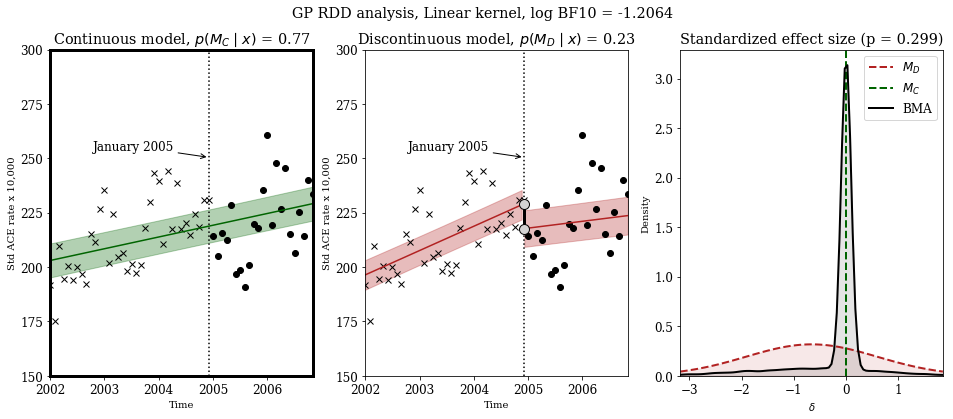

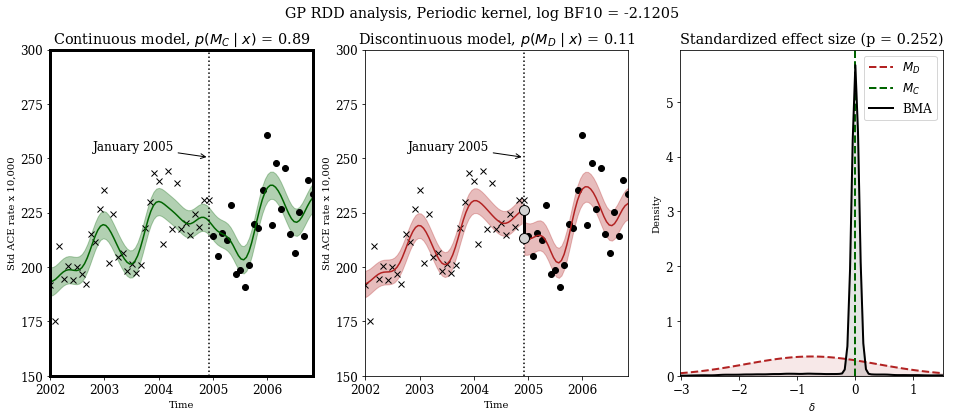

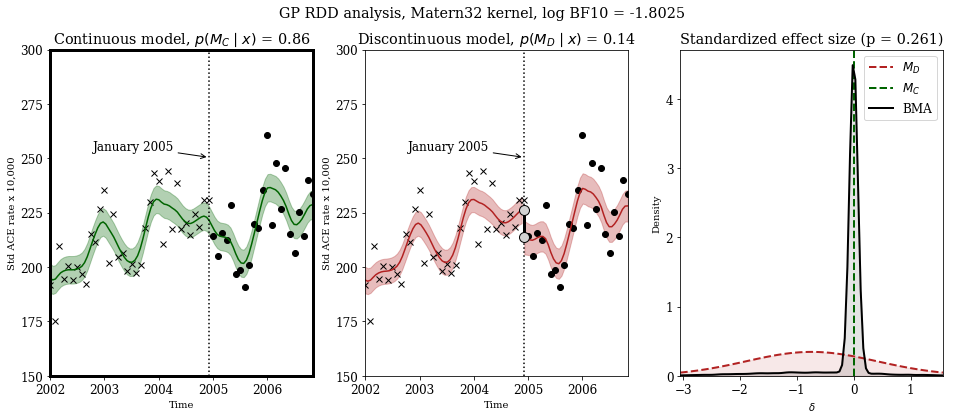

In [13]:
x_test = np.linspace(x[0], x[-1], num=100)  # interpolate between actual observations
num_restarts = 100
kernel_names = ['Linear', 'Periodic', 'Matern32']
kernels = [linear_kernel, periodic_kernel, matern32_kernel]
for kernel_name, kernel in zip(kernel_names, kernels):
    print('Training model with {} kernel'.format(kernel_name))
    
    # Train the model, i.e. optimize GP hyperparameters
    gprdd = GPRDDAnalysis.GPRDDAnalysis(x, y, kernel.copy(), labelFunc)
    gprdd.train(num_restarts=num_restarts) 
    
    # Plot the results. All statistics can also directly be accessed (see e.g. gprdd.pmp() below).
    fig, axes = gprdd.plot(x_test, plotEffectSize=True, b=bz)
    for ax in axes[0], axes[1]:
        ax.annotate('January 2005', xy=(bz, 2), xytext=(bz-1.5, 2.2), arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))
        ax.set_xticks(zscorex(np.arange(1, n, step=12)))
        ax.set_xticklabels(np.unique(data['year']))
        ax.set_yticks(zscorey(np.arange(150, 301, step=25)))
        ax.set_yticklabels(np.arange(150, 301, step=25))
        ax.set_xlabel('Time')
        ax.set_ylabel('Std ACE rate x 10,000')
    axes[2].set_title('Standardized effect size (p = {:0.3f})'.format(gprdd.discPval(b=bz)))
    fig.suptitle('GP RDD analysis, {:s} kernel, log BF10 = {:0.4f}'.format(kernel_name, gprdd.logBayesFactor()))
    
    # Estimated discontinuity according to discontinuous model.
    zpred_at_b, _ = gprdd.discEstimate(bz)
    pred_at_b = [np.squeeze(inv_zscorey(p)) for p in zpred_at_b]
    risk_reduction = 1 - pred_at_b[0] / pred_at_b[1]
    
    # Get posterior model probabilities.
    pmc, pmd = gprdd.pmp()
    print('ACE risk reduction according to discontinuous model: {:0.1f}%'.format(risk_reduction*100))
    print('ACE risk reduction according to BMA: {:0.1f}%'.format(pmd*risk_reduction*100))
    print('Bayes factor in favor of a discontinuity: {:0.4f}'.format(np.exp(gprdd.logBayesFactor())))
    print('')

We find a reduction in the relative risk of acute coronary events of 5.0%, 5.7% and 5.6%, using the linear, the periodic kernel or the Matern (3/2) kernel, respectively (slight differences due to stochastic optimization are possible). However, regardless of the kernel, the Bayes factor of the model comparison indicates that the continuous model is much more probable than the discontinuous one. 

By definition, the continuous model predicts an effect size (c.q. risk reduction, discontinuity) of 0. The optimal estimate of the true effect size is the Bayesian model averaged (BMA) estimate, which is the prediction of each model weighted by its respective probability (see e.g. this preprint by [Hinne et al., 2019](https://psyarxiv.com/wgb64)). This shows that regardless of the model, these data show little effect of the smoking ban on the prevalence of acute coronary events.